In [1]:
from datasets import load_dataset
import datasets
import torchvision
from tqdm import tqdm
from walloc.walloc import pil_to_latent
from dataset.shapebatching_dataset import ShapeBatchingDataset
from config import BS, CFG_RATIO, TRAIN_STEPS, MASK_RATIO, AE_SCALING_FACTOR, AE_CHANNELS, AE_HF_NAME, MODELS_DIR_BASE, DS_DIR_BASE, SEED, SIGLIP_EMBED_DIM, SIGLIP_HF_NAME, USERNAME, DATASET_NAME, LR
from transformers import SiglipTokenizer, SiglipTextModel
import torch
from diffusers import AutoencoderDC
from config import AE_HF_NAME, MODELS_DIR_BASE
import torch
from IPython.display import display
from torchvision.transforms.v2 import ToPILImage

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "d:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
    ^^^^^^^^^^^^^
ModuleNotFoundError: No module named 'triton'


In [2]:
datasets.config.HF_HUB_OFFLINE = 1

In [3]:
DTYPE= torch.bfloat16
device = torch.device("cuda:0")

In [4]:
ae = AutoencoderDC.from_pretrained(f"mit-han-lab/{AE_HF_NAME}", torch_dtype=DTYPE, cache_dir=f"{MODELS_DIR_BASE}/dc_ae", revision="main").to(device).eval()

In [5]:
def get_dataset(bs, seed, device, num_workers=16):
    # ds = load_dataset(f"{USERNAME}/{DATASET_NAME}", cache_dir=f"{DS_DIR_BASE}/{DATASET_NAME}", split="train", streaming=True)
    ds = load_dataset(f"{USERNAME}/{DATASET_NAME}", cache_dir=f"{DS_DIR_BASE}/{DATASET_NAME}", num_proc=num_workers, split="train")
    ds = ds.to_iterable_dataset(1000)
    siglip_model = SiglipTextModel.from_pretrained(SIGLIP_HF_NAME, cache_dir=f"{MODELS_DIR_BASE}/siglip").to(device, DTYPE)
    siglip_tokenizer = SiglipTokenizer.from_pretrained(SIGLIP_HF_NAME, cache_dir=f"{MODELS_DIR_BASE}/siglip")

    
    ds = ShapeBatchingDataset(ds, bs, siglip_tokenizer, siglip_model, device, num_workers, shuffle=False, seed=seed)
    return ds

In [6]:
ds = get_dataset(1, 13482983, device=device, num_workers=1)

Using the latest cached version of the dataset since SwayStar123/imagenet_288_dcae_fp8_captions couldn't be found on the Hugging Face Hub (offline mode is enabled).
Found the latest cached dataset configuration 'default' at ..\..\datasets\imagenet_288_dcae_fp8_captions\SwayStar123___imagenet_288_dcae_fp8_captions\default\0.0.0\d17e235ed1178494a26553a8b9fffc51252589c0 (last modified on Sat Feb 15 17:41:13 2025).


In [7]:
ds = iter(ds)

In [8]:
batch = next(ds)

In [9]:
batch

{'caption': ['A small black and gray dog with a beard and mustache, wearing a collar with a tag, sitting on a brown carpeted floor. The dog has a serious expression on its face. In the background, there is a wooden cabinet with a white door and a white column. The wall behind the dog is painted white.'],
 'label': tensor([196], dtype=torch.int32),
 'ae_latent': tensor([[[[ 3.9062e-02,  8.7500e-01,  1.1719e-01,  ..., -4.6875e-02,
            -1.0000e+00, -1.3750e+00],
           [-4.6875e-01,  2.2500e+00,  5.6250e-01,  ...,  2.2500e+00,
             8.1250e-01,  4.5000e+00],
           [-1.5000e+00, -3.7500e-01, -3.4375e-01,  ...,  1.2500e+00,
             7.5000e-01,  4.0000e+00],
           ...,
           [-3.4375e-01,  5.0000e-01,  5.6250e-01,  ...,  2.7500e+00,
             2.2500e+00, -2.5000e+00],
           [ 4.0625e-01,  2.5000e+00, -2.5000e+00,  ...,  7.5000e-01,
            -7.5000e-01, -1.5000e+00],
           [-4.5000e+00, -2.2500e+00, -3.4375e-01,  ...,  2.8125e-01,
      

In [10]:
latent = batch["ae_latent"].to(device, dtype=torch.bfloat16)[0]

In [11]:
latent

tensor([[[ 3.9062e-02,  8.7500e-01,  1.1719e-01,  ..., -4.6875e-02,
          -1.0000e+00, -1.3750e+00],
         [-4.6875e-01,  2.2500e+00,  5.6250e-01,  ...,  2.2500e+00,
           8.1250e-01,  4.5000e+00],
         [-1.5000e+00, -3.7500e-01, -3.4375e-01,  ...,  1.2500e+00,
           7.5000e-01,  4.0000e+00],
         ...,
         [-3.4375e-01,  5.0000e-01,  5.6250e-01,  ...,  2.7500e+00,
           2.2500e+00, -2.5000e+00],
         [ 4.0625e-01,  2.5000e+00, -2.5000e+00,  ...,  7.5000e-01,
          -7.5000e-01, -1.5000e+00],
         [-4.5000e+00, -2.2500e+00, -3.4375e-01,  ...,  2.8125e-01,
          -2.0000e+00, -6.8750e-01]],

        [[ 1.7500e+00,  2.2500e+00,  1.8750e+00,  ...,  1.8750e+00,
           1.5000e+00,  4.3750e-01],
         [ 1.1250e+00,  1.7500e+00,  1.5000e+00,  ...,  1.5000e+00,
           9.3750e-01,  1.5625e-01],
         [-5.4688e-02, -4.0625e-01,  1.2500e+00,  ...,  4.3750e-01,
           1.8750e+00, -2.3438e-01],
         ...,
         [ 1.8750e+00,  3

In [12]:
x = ae.decoder(latent.unsqueeze(0)).squeeze()

In [13]:
x.shape

torch.Size([3, 288, 384])

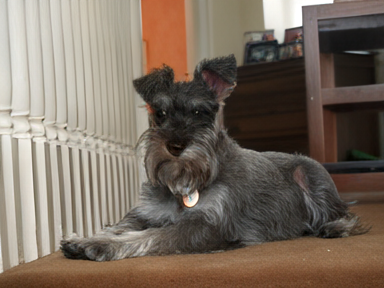

In [14]:
display(ToPILImage()((x.clamp(-0.5, 0.5)+0.5).to(torch.float32)))

In [15]:
grid = torchvision.utils.make_grid(x, nrow=2, normalize=True, scale_each=True)
torchvision.utils.save_image(grid, f"test.png")
